# Detecting Fraudulent Financial Transactions

The purpose of this analysis is to initially explore the data to identify variables that correlate with fraudulent transactions, cleanse the data, and exclude any data we deem to be irrelevant.

This cleansed dataset will then be fed into our machine learning model to developer a generalized model for fraud detection.

NB: At first glance, this data looks to be be heavily skewed towards fraudulent orders hidden within repeat customer orders, so the eventual model will be better suited to identifying repeat order fraud, and much less so first order fraud.
    - This is based on the understanding that `step` is the x order placed by a customer for a merchant, but this may be incorrect.

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from util.data_access import load_data
from util.preprocess import preprocess, cat_columns, drop_columns, print_description

pd.set_option('display.expand_frame_repr', False)

df_raw = load_data()
print("Length of dataset:", len(df_raw))

df_raw.head()

Length of dataset: 594643


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Initial Comments
based on the Pandas profiling report

## Data Cleansing
- 52 non-fraudulent orders have an order amount of 0. None of these orders are fraudulent, so I believe it's safe to remove these orders.
- zipMerchant and zipCodeOri are both constant, providing no value. These columns can be removed.

## Data Patterns
- Average number of orders placed per customer is 95.
- Only 4000 customers with 594643 orders, meaning our dataset is highly skewed towards repeat order fraud detection. This is due to the nature our dataset is synthetic.
- Gender is highly correlated with age. This skews our model as there should be no significant correlation between gender and age.
- Only 50 merchants, and merchant is highly correlated with fraud.
- Data is extremely skewed towards the `es_transportation` category (85% of all orders). 

- Age
    - 0: <=18
    - 1: 19-25
    - 2: 26-35
    - 3: 36-45
    - 4: 46-55
    - 5: 56-65
    - 6: >65
    - U: Unknown

- Gender
    - E: Enterprise
    - F: Female
    - M: Male
    - U: Unkown

In [16]:
print("Length of 0 amount orders:", len(df_raw.query('amount == 0')))
assert len(df_raw.query('amount == 0 and fraud == 1')) == 0

drop_columns = ['zipMerchant','zipcodeOri']
df = preprocess(df_raw, cat_columns, drop_columns) 


Length of 0 amount orders: 52


In [17]:
## Data Subsets
df_fraud = df[df.loc[:,'fraud'] == 1]
df_no_fraud = df[df.loc[:,'fraud'] == 0]

customer_grouping = df.groupby('customer')['fraud'].value_counts(normalize=True).rename('proportion').reset_index(level=1)
merchant_grouping = df.groupby('merchant')['fraud'].value_counts(normalize=True).rename('proportion').reset_index(level=1)
average_amount_by_customer = df.groupby('customer')['amount'].mean()
unique_transactions_by_customer = df.groupby('customer').count()['fraud'].sort_values()
fraud_proportion_by_category = df.groupby(by=["category"])['fraud'].value_counts(normalize=True).rename('proportion').reset_index()


non_fraud_customer_ids = customer_grouping.query('fraud == 0').query('proportion == 1').reset_index()['customer']
fraud_customer_ids = df[~df['customer'].isin(non_fraud_customer_ids)]['customer'].unique()
assert len(non_fraud_customer_ids) + len(fraud_customer_ids) == len(df.customer.unique())

df_fraud_customer = df[df.customer.isin(fraud_customer_ids)]
df_non_fraud_customer = df[df.customer.isin(non_fraud_customer_ids)]


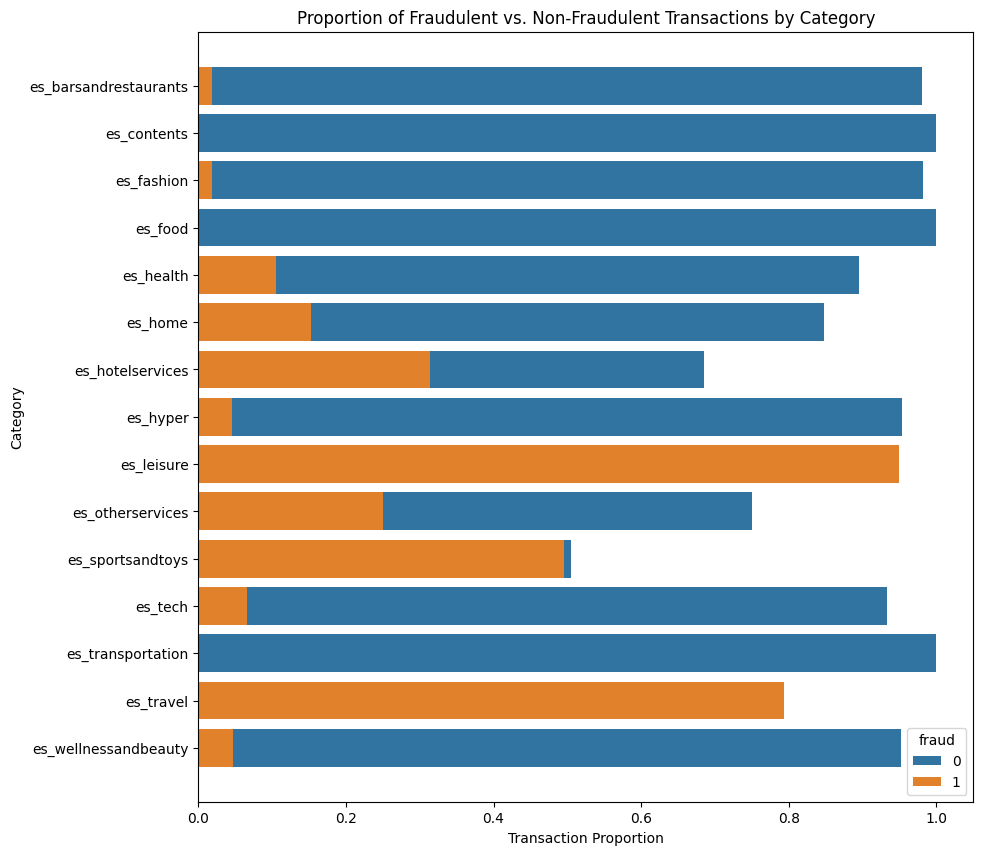

In [18]:
# Percentage of fraudulent orders
fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.barplot(
    data=fraud_proportion_by_category,
    y='category',
    x='proportion',
    hue='fraud',
    ax=ax,
    dodge=False
)
ax.set_xlabel('Transaction Proportion')
ax.set_ylabel('Category')
ax.set_title('Proportion of Fraudulent vs. Non-Fraudulent Transactions by Category')
ax.plot();

Absolutely no fraudulent transactions were in category es_transportation with 85% of all orders.

In [19]:
assert len(df.query('category.str.contains("es_transportation") and fraud == 1')) == 0

## Fraud Percentages by Category

1. `es_leisure`: 95%
2. `es_travel`: 79%
3. `es_sportsandtoys`: 50%
4. `es_hotelservices`: 31%
5. `es_otherservices`: 25%
6. `es_home`: 15%
7. `es_health`: 11%
8. `es_tech`: 7%
9. `es_wellnessandbeauty`: 5%
10. `es_hyper`: 5%
11. `es_barsandrestaurants`: 2%
12. `es_fashion`: 2%
13: `es_contents`, `es_food`, `es_transportation`: 0%

In [20]:
merchant_grouping[merchant_grouping['fraud'] == 1].sort_values('proportion',ascending=False) 

,fraud,proportion
merchant,,
M1294758098,1,0.963351
M3697346,1,0.941558
M1873032707,1,0.864000
M732195782,1,0.851974
M980657600,1,0.832109
M1353266412,1,0.820513
M857378720,1,0.754098
M2080407379,1,0.750000
M2011752106,1,0.680328


## Highest Fraud Rates per Merchant
- 'M1294758098': 0.963351
- 'M3697346': 0.941558
- 'M1873032707': 0.864000
- 'M732195782': 0.851974
- 'M980657600': 0.832109
- 'M1353266412': 0.820513
- 'M857378720': 0.754098
- 'M2080407379': 0.750000
- 'M2011752106': 0.680328
- 'M17379832': 0.631206
- 'M2122776122': 0.586510

Interesting note: Only 30 merchants had fraudulent transactions placed. Really low number.

In [21]:
customer_grouping[customer_grouping['fraud'] == 1].sort_values('proportion',ascending=False).query('proportion > 0.5')
# Potentially some more complex analysis here to understand the percentiles (how many customers commit fraud 90-100% of the time, 80-90% etc)

,fraud,proportion
customer,,
C910454738,1,0.945652
C2004941826,1,0.944444
C381007057,1,0.890000
C1572610482,1,0.881188
C617723960,1,0.869565
C2113737065,1,0.868132
C2060410910,1,0.846154
C483912131,1,0.816327
C1809646275,1,0.800000


In [22]:
df['moving'] = df.groupby(['customer'])['amount'].transform(lambda x: x.rolling(10, 1).mean())

In [23]:
df['Transactions Completed'] = 1
MAX_CUSTOMER_TRANSACTIONS = df.groupby('customer')['fraud'].count().max()
df['Customer Transaction Number'] = df.groupby(['customer'])['Transactions Completed'].transform(lambda x: x.rolling(MAX_CUSTOMER_TRANSACTIONS, 1).sum())

# Highest Fraud Rates per Customer
- 'C910454738': 0.945652
- 'C2004941826': 0.944444
- 'C381007057': 0.890000
- 'C1572610482': 0.881188
- 'C617723960': 0.869565
- 'C2113737065': 0.868132
- 'C2060410910': 0.846154
- 'C483912131': 0.816327
- 'C1809646275': 0.800000
- 'C1817318774': 0.776786
- 'C1350963410': 0.753927
- 'C1849046345': 0.742690
- 'C1175850429': 0.725664
- 'C371517012': 0.720000
- 'C1233811793': 0.714286
- 'C1454826238': 0.700000
- 'C126638730': 0.681818
- 'C611182051': 0.671642
- 'C1803182614': 0.666667
- 'C231476583': 0.640000
- 'C1464489812': 0.634783
- 'C932908444': 0.632353
- 'C1237248073': 0.629630
- 'C650117238': 0.625000
- 'C245117318': 0.620370
- 'C1685492470': 0.606742
- 'C1562081159': 0.600000
- 'C1338125837': 0.552632
- 'C204205576': 0.550000
- 'C616715154': 0.547619
- 'C751887992': 0.541667
- 'C1560904250': 0.538462
- 'C1994178184': 0.537736
- 'C806399525': 0.527426
- 'C1163388474': 0.526316
- 'C894204131': 0.523810
- 'C1653588482': 0.517857

## How Many Transactions are Customers Making?
By grouping the data on the customer, we observe the following:
- Customers can make anywhere from 5 to 265 Transactions over the 180 Steps
- Most customers lie within the range of 150-180 transactions (i.e. are making a transaction/day)
- There is a sharp dropoff after 180 transactions, with only 3% of customers having more than 180 Transactions

Feature Possibilities:
- Average Value of Previous Transactions
- Number of Previous Transactions
- Has Been Fraudulent in a Previous Transaction

Fraud Overview
--------------
count    4112.000000
mean      144.611625
std        42.788212
min         5.000000
25%       130.000000
50%       165.000000
75%       173.000000
max       265.000000
Name: fraud, dtype: float64
--------------
Proportion of Customers with >180 Transactions: 0.03


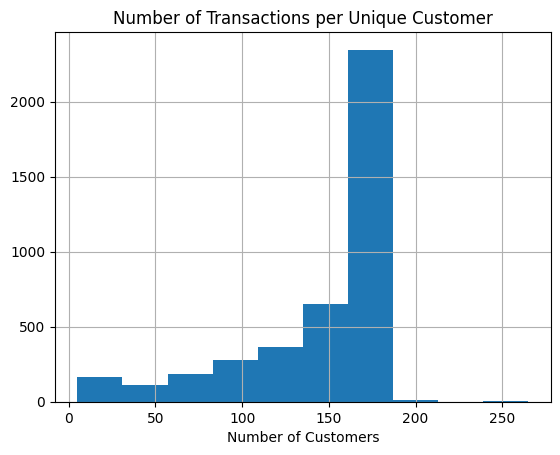

In [24]:
import matplotlib.pyplot as plt
print_description(unique_transactions_by_customer)
print(f'Proportion of Customers with >180 Transactions: {unique_transactions_by_customer[unique_transactions_by_customer > 180].count() / unique_transactions_by_customer.count():.2f}')


ax = unique_transactions_by_customer.hist()
ax.set_xlabel('Number of Transactions')
ax.set_xlabel('Number of Customers')
ax.set_title('Number of Transactions per Unique Customer')
ax.plot();

## Amount

Amount Overview
--------------
count    594643.000000
mean         37.890135
std         111.402831
min           0.000000
25%          13.740000
50%          26.900000
75%          42.540000
max        8329.960000
Name: amount, dtype: float64
--------------
Customer Overview
--------------
count          594643
unique           4112
top       C1978250683
freq              265
Name: customer, dtype: object
--------------


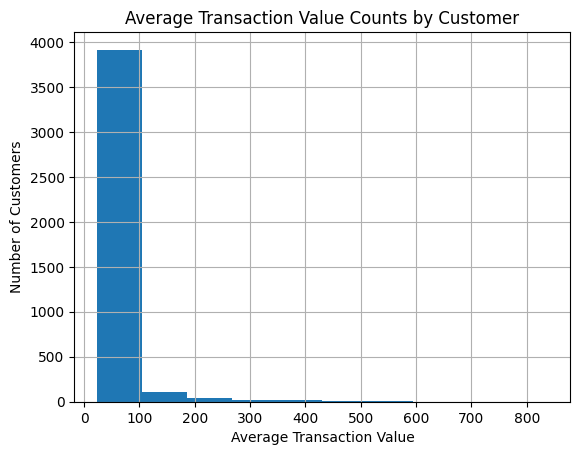

In [25]:
print_description(df['amount'])
print_description(df['customer'])

ax = average_amount_by_customer.hist()

ax.set_xlabel('Average Transaction Value')
ax.set_ylabel('Number of Customers')
ax.set_title('Average Transaction Value Counts by Customer')
ax.plot();

## Separation between Fraudulent & Non-Fraudulent Transactions by Amount

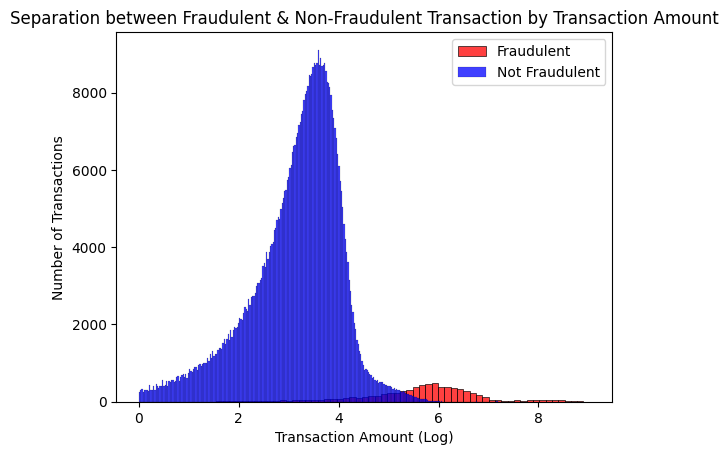

In [26]:
fig, ax = plt.subplots(1,1)
sns.histplot(np.log1p(df_fraud['amount']), color='red', ax=ax)
sns.histplot(np.log1p(df_no_fraud['amount']), color='blue', ax=ax)
ax.legend(labels=['Fraudulent','Not Fraudulent'])
ax.set_xlabel('Transaction Amount (Log)')
ax.set_ylabel('Number of Transactions')
ax.set_title('Separation between Fraudulent & Non-Fraudulent Transaction by Transaction Amount')
ax.plot();

<AxesSubplot: xlabel='log_amount', ylabel='category'>

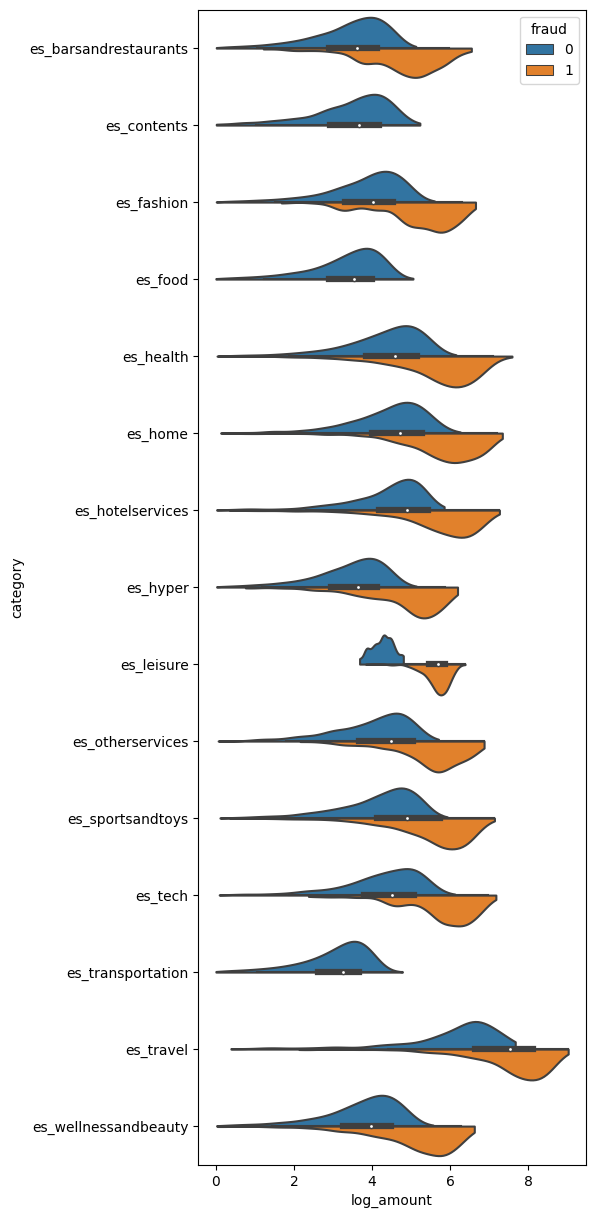

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,15))
df['log_amount'] = np.log1p(df['amount'])
sns.violinplot(
    data=df, x="log_amount", y="category", hue="fraud",
    bw=.25, cut=0, split=True,
    ax=ax
)